# Using ML models Predicting Volatility
- Afet Ibadova 453818
- Daryush Ray 455894

## Introduction
**The aim of the Project** - (this part need to be added)

In [6]:
!pip install yfinance
!pip install ta

In [7]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


## Import libraries and data

In [9]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cycler
import seaborn as sns
import ta
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

# For time stamps
from datetime import datetime

#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [10]:
# import data SP500
df = yf.download("SP")
df.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

## Investigate data

In [11]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4936.000000,4936.000000,4936.000000,4936.000000,4936.000000,4.936000e+03
mean,23.772882,24.127306,23.398523,23.765785,23.765785,7.829639e+04
std,9.330066,9.415053,9.242895,9.319622,9.319622,1.164928e+05
min,5.975000,6.075000,5.930000,5.990000,5.990000,0.000000e+00
25%,17.320000,17.628749,17.000000,17.330000,17.330000,3.370000e+04
50%,22.150000,22.490000,21.740000,22.180000,22.180000,5.600000e+04
75%,31.182500,31.639999,30.650000,31.190001,31.190001,9.250000e+04
max,52.290001,52.400002,51.500000,51.700001,51.700001,4.820400e+06


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4936 entries, 2004-06-02 to 2024-01-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4936 non-null   float64
 1   High       4936 non-null   float64
 2   Low        4936 non-null   float64
 3   Close      4936 non-null   float64
 4   Adj Close  4936 non-null   float64
 5   Volume     4936 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 269.9 KB


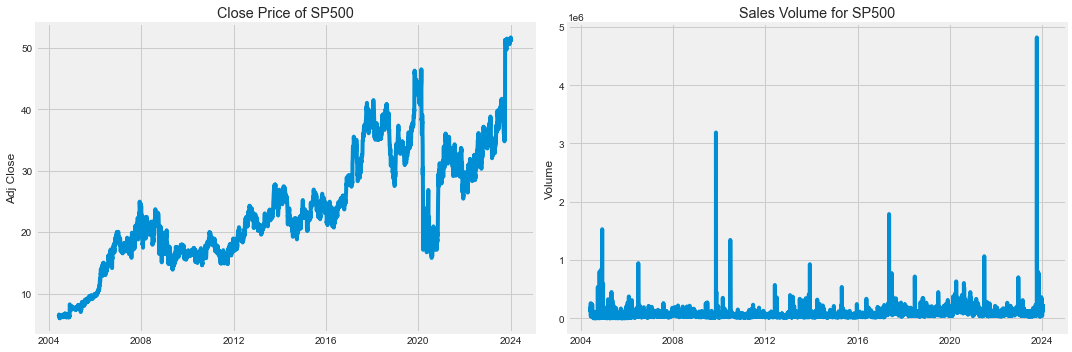

In [14]:
# Create a 1x2 subplot grid (one row, two columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), linewidth=1)

# Plot the first subplot (Closing Price - Adj Close)
axs[0].plot(df.index, df['Adj Close'])
axs[0].set_ylabel('Adj Close')
axs[0].set_xlabel(None)
axs[0].set_title('Close Price of SP500')

# Plot the second subplot (Volume)
axs[1].plot(df.index, df['Volume'])
axs[1].set_ylabel('Volume')
axs[1].set_xlabel(None)
axs[1].set_title("Sales Volume for SP500")

# Adjust the layout
plt.tight_layout()

# Show the combined plot
plt.show()


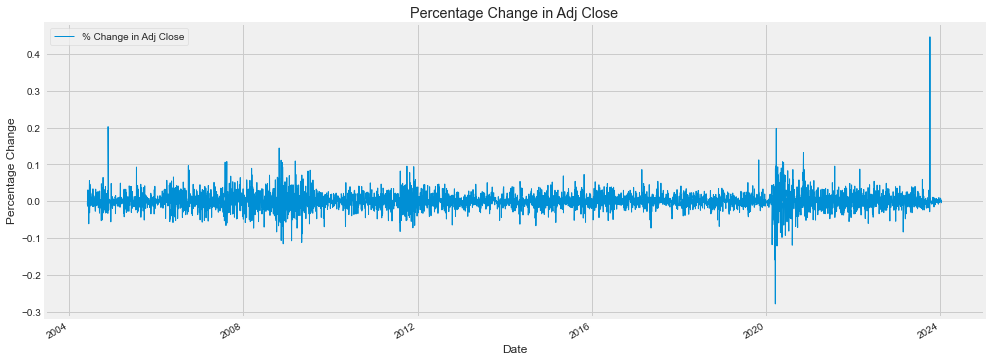

In [15]:
def plot_percentage_change_adj_close(df):
    df["Adj Close"].pct_change().plot(figsize=(15, 6),linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.title('Percentage Change in Adj Close')
    plt.legend(['% Change in Adj Close'])
    plt.show()


plot_percentage_change_adj_close(df)


Let's get an overall look at the average daily return using a histogram.

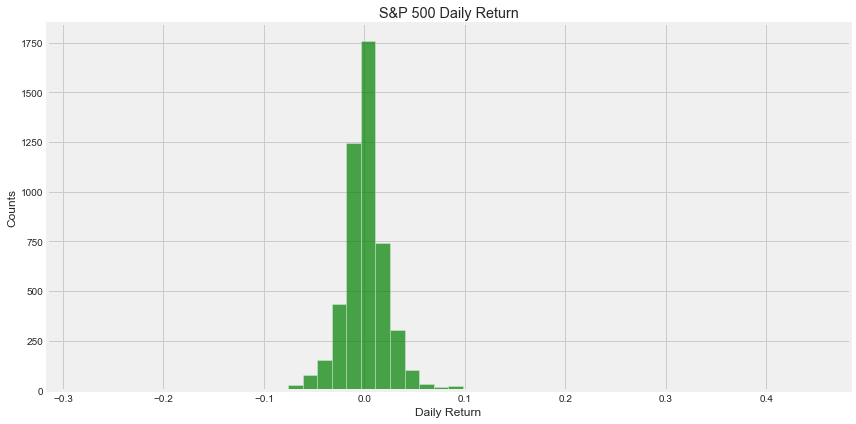

In [16]:
plt.figure(figsize=(12, 6))
df["Adj Close"].pct_change().hist(bins=50, color='green', alpha=0.7)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('S&P 500 Daily Return')
plt.tight_layout()
plt.show()

## Feature Engineering

**A Simple Moving Average (SMA)** is a technical indicator that calculates the average of a selected range of prices, typically closing prices, over a specified number of periods. It smooths out price data by filtering out the noise from random short-term fluctuations. The SMA is used in technical analysis to identify trends and potential reversals in a market.

**Moving Standard Deviation (MSD)** is a statistical measure that quantifies the variability or dispersion of a set of data points within a moving window over time. In financial markets, it's used to assess the volatility of an asset's price by calculating the standard deviation of the prices within a given time frame, which moves forward with each new period. This indicator helps traders understand the magnitude of price fluctuations and can be used to identify periods of high risk or potential trading opportunities.

**The relative strength index (RSI)** is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.



In [17]:
def feature_engineering(df):
    """ Create new variables"""
    
    # copy the dataframe to avoid interferences in the data
    df_copy = df.copy()
    df_copy = df_copy.fillna(method='ffill')
    
    # Create the returns
    df_copy["returns"] = df_copy["Close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["Close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["Close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)
    
    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["Close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    return df_copy.dropna()

In [19]:
dfc = yf.download("SP")

[*********************100%***********************]  1 of 1 completed


In [20]:
dfc.info

<bound method DataFrame.info of                  Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2004-06-02   6.235000   6.545000   6.165000   6.545000   6.545000  109200
2004-06-03   6.550000   7.345000   6.485000   6.485000   6.485000  186400
2004-06-04   6.650000   6.650000   6.445000   6.475000   6.475000  146200
2004-06-07   6.450000   6.615000   6.350000   6.395000   6.395000  120800
2004-06-08   6.425000   6.760000   6.425000   6.590000   6.590000  258200
...               ...        ...        ...        ...        ...     ...
2024-01-04  51.900002  51.900002  51.400002  51.599998  51.599998  110600
2024-01-05  51.509998  52.000000  51.500000  51.590000  51.590000  150000
2024-01-08  51.580002  51.840000  51.349998  51.360001  51.360001  221800
2024-01-09  51.240002  51.500000  51.110001  51.209999  51.209999  167200
2024-01-10  51.220001  51.500000  51.220001  51.400002  51.400002  244376

[4936

In [21]:
dfc = feature_engineering(dfc)
dfc

,Open,High,Low,Close,Adj Close,Volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,,,,,,
2004-08-27,6.600000,6.600000,6.600000,6.600000,6.600000,0,0.000000,6.360333,6.348917,0.012974,0.014127,62.093858
2004-08-30,6.600000,6.600000,6.600000,6.600000,6.600000,0,0.000000,6.375333,6.349833,0.012311,0.013951,62.093858
2004-08-31,6.575000,6.625000,6.525000,6.525000,6.525000,25400,-0.011364,6.402000,6.351750,0.010874,0.013620,56.373709
2004-09-01,6.695000,6.725000,6.490000,6.695000,6.695000,2200,0.026054,6.423667,6.352583,0.012072,0.012428,64.382934
2004-09-02,6.510000,6.710000,6.510000,6.710000,6.710000,16000,0.002240,6.460000,6.357583,0.013652,0.013293,64.993612
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,51.900002,51.900002,51.400002,51.599998,51.599998,110600,-0.001934,51.172666,50.879667,0.004570,0.004594,60.934819
2024-01-05,51.509998,52.000000,51.500000,51.590000,51.590000,150000,-0.000194,51.207999,50.887167,0.003769,0.004200,60.696636
2024-01-08,51.580002,51.840000,51.349998,51.360001,51.360001,221800,-0.004458,51.230666,50.893000,0.003572,0.004203,55.338008


<AxesSubplot:xlabel='Date'>

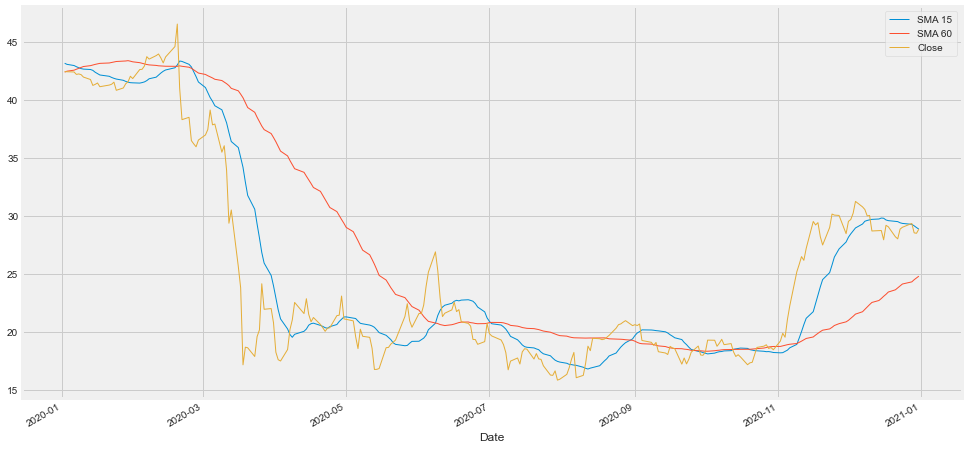

In [22]:
dfc[["SMA 15", "SMA 60", "Close"]].loc["2020"].plot(figsize=(15,8), linewidth=1)

<AxesSubplot:xlabel='Date'>

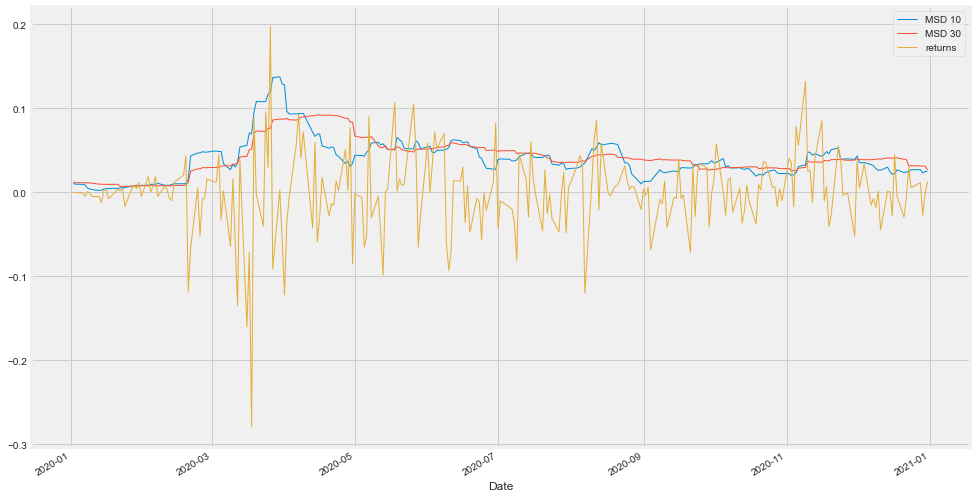

In [23]:
dfc[["MSD 10", "MSD 30", "returns"]].loc["2020"].plot(figsize=(15,9), linewidth=1)

<AxesSubplot:xlabel='Date'>

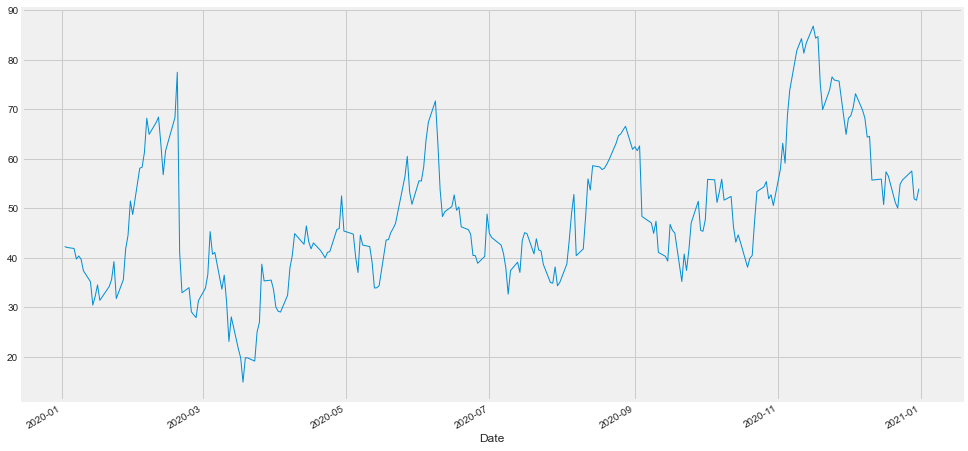

In [24]:
dfc["rsi"].loc["2020"].plot(figsize=(15,8), linewidth=1)

## Predicting stock price

### LSTM

In [25]:
# Create a new dataframe with only the 'Close column 
data = dfc.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

3901

In [26]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01085645],
       [0.01085645],
       [0.00921154],
       ...,
       [0.99254304],
       [0.98925317],
       [0.99342035]])

In [27]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.01085645, 0.01085645, 0.00921154, 0.01294002, 0.013269  ,
       0.01063713, 0.00866323, 0.01140476, 0.01414629, 0.01414629,
       0.0093212 , 0.013269  , 0.01414629, 0.01414629, 0.01414629,
       0.01414629, 0.01140476, 0.00877289, 0.00833425, 0.00888256,
       0.00866323, 0.00109662, 0.00745696, 0.01074679, 0.00416712,
       0.00921154, 0.00186424, 0.00285119, 0.00043864, 0.00043864,
       0.00537339, 0.00416712, 0.01304967, 0.00833425, 0.01019849,
       0.00943085, 0.0059217 , 0.00438644, 0.00427679, 0.00427679,
       0.00493475, 0.00921154, 0.0093212 , 0.00921154, 0.00745696,
       0.0033995 , 0.00888256, 0.00427679, 0.00657967, 0.00701832,
       0.00263186, 0.        , 0.00219322, 0.00427679, 0.00712797,
       0.00449611, 0.00296085, 0.00208356, 0.0039478 , 0.00789561])]
[0.003180172794404884]

[array([0.01085645, 0.01085645, 0.00921154, 0.01294002, 0.013269  ,
       0.01063713, 0.00866323, 0.01140476, 0.01414629, 0.01414629,
       0.0093212 , 0.013269  , 0.0

In [28]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)




3841/3841 [==============================] - 276s 71ms/step - loss: 7.4196e-04


In [29]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

31/31 [==============================] - 7s 47ms/step


1.2558442580100726

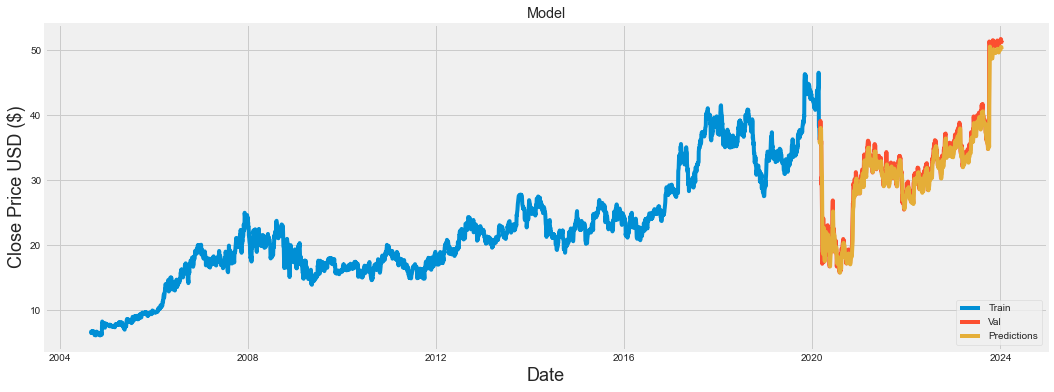

In [32]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()
valid['Predictions'] = predictions

valid.loc[:, 'Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6), linewidth=1)
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()